In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import sas dataset
# Here encodings = 'latin-1' because if we import without specifing encoding, the text comes as b'text'

df = pd.read_sas('et_201801_202103_with_preds_new.sas7bdat', format = 'sas7bdat', encoding= 'latin-1')

In [3]:
# Taking out only relevant features

# TRADE_ACTIONED_IND = Dependent Variable
# TRD_SUBMIT_YYYYMM  = YEAR-MONTH VARIABLE
# PREDICTION         = Prediction Score

df = df[['TRADE_ACTIONED_IND', 'TRD_SUBMIT_YYYYMM', 'PREDICTION']]

In [4]:
df.head(5)

,TRADE_ACTIONED_IND,TRD_SUBMIT_YYYYMM,PREDICTION
0,1.0,201904,0.095573
1,0.0,201904,0.730588
2,0.0,201904,0.248025
3,0.0,201904,0.209386
4,0.0,201904,0.176912


In [5]:
df.shape

(75414, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75414 entries, 0 to 75413
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TRADE_ACTIONED_IND  75414 non-null  float64
 1   TRD_SUBMIT_YYYYMM   75414 non-null  object 
 2   PREDICTION          75414 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.7+ MB


In [19]:
# Training Dataset = JAN2018 - APR2019
df_train = df[df['TRD_SUBMIT_YYYYMM'] < '201905']
df_train.shape

(22295, 3)

In [20]:
# Out of Time Validation Dataset 1 = MAY2019 - DEC2019
df_val_1 = df[df['TRD_SUBMIT_YYYYMM'] < '202001']
df_val_1 = df_val_1[df_val_1['TRD_SUBMIT_YYYYMM'] > '201904']
df_val_1.shape

(18238, 3)

In [21]:
# Out of Time Validation Dataset 2 = JAN2020 - DEC2020 
df_val_2 = df[df['TRD_SUBMIT_YYYYMM'] > '201912']
df_val_2 = df_val_2[df_val_2['TRD_SUBMIT_YYYYMM'] < '202101']
df_val_2.shape

(27767, 3)

## Lift / Gain Chart Report

In [10]:
def lift_chart(data):
    # Sort data by Prediction

    data=data.sort_values(by=['PREDICTION'], ascending=[False])

    # Add a very small random number to the probability to break ties
    data['wookie'] = (np.random.randint(0, 100, data.shape[0]))/100000000000000000
    data['PREDICTION']=data['PREDICTION']+data['wookie']

    #Create deciles based on P_FAIL
    data['DECILE'] = pd.qcut(data['PREDICTION'], 10, labels=np.arange(10, 0, -1))

    # Find the minimum probability for each decile
    min_score = pd.DataFrame(data.groupby(['DECILE'])['PREDICTION'].min())

    # Find the average probability of each decile
    avg_score = pd.DataFrame(data.groupby(['DECILE'])['PREDICTION'].mean())

    # Find the maximum probability of each decile
    max_score = pd.DataFrame(data.groupby(['DECILE'])['PREDICTION'].max())

    # Find the Actual ACTION rate for each decile.
    action_rate = pd.DataFrame(data.groupby(['DECILE'])['TRADE_ACTIONED_IND'].mean())*100

    #Sum the number of ACTIONS in each decile.
    actions = pd.DataFrame(data.groupby(['DECILE'])['TRADE_ACTIONED_IND'].sum())

    # count the records in each decile
    obs = pd.DataFrame(data.groupby(['DECILE'])['TRADE_ACTIONED_IND'].count())

    #Aggregate the summaries into one dataframe
    tips = pd.concat([min_score,avg_score,max_score, action_rate, actions,obs], axis=1)
    tips.columns = ['MIN_SCORE','AVG_SCORE','MAX_SCORE','ACTION_RATE','ACTIONS', 'OBS']
    tips=tips.sort_values(by=['DECILE'], ascending=[False])
    gains=tips

    #Find the number of cumulative action trades by decile.
    gains['CUML_ACTIONS']=gains['ACTIONS'].cumsum()

    #Find the number of fallout actions by decile.
    gains['FALLOUT_ACTIONS']=data['TRADE_ACTIONED_IND'].sum() - gains['CUML_ACTIONS']

    #Find the percentage of fallout in each decile
    gains['PCT_OF_FALLOUT']=(gains.FALLOUT_ACTIONS)/(data['TRADE_ACTIONED_IND'].sum())*100

    #Find the percentage of actions in each decile
    gains['PCT_OF_ACTIONS']=(gains.ACTIONS)/(data['TRADE_ACTIONED_IND'].sum())*100

    #Find the cumulative percentage of actions in each decile.
    gains['CUML_PCT_OF_ACTIONS']=gains.PCT_OF_ACTIONS.cumsum()

    #Format the final output
    gains=gains[['OBS','ACTIONS','ACTION_RATE','MIN_SCORE','AVG_SCORE','MAX_SCORE','CUML_ACTIONS', 'CUML_PCT_OF_ACTIONS', 'FALLOUT_ACTIONS', 'PCT_OF_FALLOUT']]

    return gains

In [11]:
lift_chart_train = lift_chart(df_train)
lift_chart_train

,OBS,ACTIONS,ACTION_RATE,MIN_SCORE,AVG_SCORE,MAX_SCORE,CUML_ACTIONS,CUML_PCT_OF_ACTIONS,FALLOUT_ACTIONS,PCT_OF_FALLOUT
DECILE,,,,,,,,,,
1,2230,1390.0,62.331839,0.434064,0.568512,0.902504,1390.0,32.938389,2830.0,67.061611
2,2229,907.0,40.690893,0.325345,0.372699,0.433999,2297.0,54.431280,1923.0,45.568720
3,2230,714.0,32.017937,0.230032,0.277218,0.325181,3011.0,71.350711,1209.0,28.649289
4,2229,388.0,17.406909,0.160079,0.191744,0.229976,3399.0,80.545024,821.0,19.454976
5,2229,307.0,13.772992,0.120130,0.138572,0.160044,3706.0,87.819905,514.0,12.180095
6,2230,227.0,10.179372,0.089878,0.104641,0.120126,3933.0,93.199052,287.0,6.800948
7,2229,158.0,7.088380,0.060993,0.075551,0.089843,4091.0,96.943128,129.0,3.056872
8,2230,78.0,3.497758,0.034298,0.047419,0.060971,4169.0,98.791469,51.0,1.208531
9,2229,46.0,2.063706,0.011898,0.022600,0.034290,4215.0,99.881517,5.0,0.118483


In [12]:
lift_chart_val_1 = lift_chart(df_val_1)
lift_chart_val_1

,OBS,ACTIONS,ACTION_RATE,MIN_SCORE,AVG_SCORE,MAX_SCORE,CUML_ACTIONS,CUML_PCT_OF_ACTIONS,FALLOUT_ACTIONS,PCT_OF_FALLOUT
DECILE,,,,,,,,,,
1,1824,853.0,46.765351,0.405457,0.519747,0.875896,853.0,21.649746,3087.0,78.350254
2,1824,767.0,42.050439,0.356153,0.377823,0.405449,1620.0,41.116751,2320.0,58.883249
3,1824,737.0,40.405702,0.320487,0.338323,0.356149,2357.0,59.822335,1583.0,40.177665
4,1823,704.0,38.617663,0.274786,0.299220,0.320479,3061.0,77.690355,879.0,22.309645
5,1824,370.0,20.285088,0.211476,0.241209,0.274774,3431.0,87.081218,509.0,12.918782
6,1824,183.0,10.032895,0.153246,0.183677,0.211467,3614.0,91.725888,326.0,8.274112
7,1823,145.0,7.953922,0.111235,0.131087,0.153109,3759.0,95.406091,181.0,4.593909
8,1824,113.0,6.195175,0.073813,0.092470,0.111189,3872.0,98.274112,68.0,1.725888
9,1824,57.0,3.125000,0.032657,0.054485,0.073813,3929.0,99.720812,11.0,0.279188


In [13]:
lift_chart_val_2 = lift_chart(df_val_2)
lift_chart_val_2

,OBS,ACTIONS,ACTION_RATE,MIN_SCORE,AVG_SCORE,MAX_SCORE,CUML_ACTIONS,CUML_PCT_OF_ACTIONS,FALLOUT_ACTIONS,PCT_OF_FALLOUT
DECILE,,,,,,,,,,
1,2777,1330.0,47.893410,0.434984,0.547488,0.889656,1330.0,17.145804,6427.0,82.854196
2,2777,1052.0,37.882607,0.382395,0.402327,0.434870,2382.0,30.707748,5375.0,69.292252
3,2776,1032.0,37.175793,0.353781,0.367860,0.382391,3414.0,44.011860,4343.0,55.988140
4,2777,1002.0,36.082103,0.328357,0.340948,0.353780,4416.0,56.929225,3341.0,43.070775
5,2776,934.0,33.645533,0.300666,0.314698,0.328348,5350.0,68.969963,2407.0,31.030037
6,2777,855.0,30.788621,0.261874,0.282503,0.300594,6205.0,79.992265,1552.0,20.007735
7,2777,745.0,26.827512,0.206770,0.235245,0.261865,6950.0,89.596493,807.0,10.403507
8,2776,440.0,15.850144,0.142635,0.170656,0.206732,7390.0,95.268789,367.0,4.731211
9,2777,242.0,8.714440,0.097081,0.120715,0.142627,7632.0,98.388552,125.0,1.611448


### Ploting Lift Charts

C:\Users\avasis\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\avasis\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


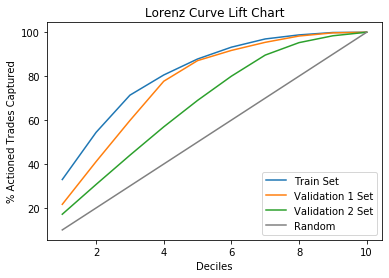

In [14]:
# train set points
x1 = [1,2,3,4,5,6,7,8,9,10]
y1 = lift_chart_train['CUML_PCT_OF_ACTIONS']
# plotting train set points 
plt.plot(x1, y1, label = "Train Set")

# val 1 set points
x2 = [1,2,3,4,5,6,7,8,9,10]
y2 = lift_chart_val_1['CUML_PCT_OF_ACTIONS']
# plotting val 1 set points 
plt.plot(x2, y2, label = "Validation 1 Set")

# val 2 set points
x3 = [1,2,3,4,5,6,7,8,9,10]
y3 = lift_chart_val_2['CUML_PCT_OF_ACTIONS']
# plotting val 2 set points 
plt.plot(x3, y3, label = "Validation 2 Set")

# Random set points
x4 = [1,2,3,4,5,6,7,8,9,10]
y4 = [10,20,30,40,50,60,70,80,90,100]
# plotting Random set points 
plt.plot(x4, y4, label = "Random", color='gray')

# naming the x axis
plt.xlabel('Deciles')
# naming the y axis
plt.ylabel('% Actioned Trades Captured')
# giving a title to my graph
plt.title('Lorenz Curve Lift Chart')
  
# show a legend on the plot
plt.legend()

# function to show the plot
plt.show()

## Year-Month Report

In [15]:
def year_month_report(data, thresh):
    #------------------------------------------------------------------#
    #-------------------------# Overall Data #-------------------------#
    #------------------------------------------------------------------#
    # Total trades grouped by year-month
    total_trades = pd.DataFrame(data.groupby(['TRD_SUBMIT_YYYYMM'])['TRADE_ACTIONED_IND'].count())

    # Total actioned trades grouped by year-month
    total_actions = pd.DataFrame(data.groupby(['TRD_SUBMIT_YYYYMM'])['TRADE_ACTIONED_IND'].sum())

    # Ratio of Actioned trades by Total trades, grouped by year-month
    action_rate = (total_actions / total_trades) *100

    #----------------------------------------------------------------------------#
    #-------------------------# Trades above Threshold #-------------------------#
    #----------------------------------------------------------------------------#
    # Creating new dataset with trades above threshold value
    data_2 = data[data.PREDICTION > thresh]

    # Total trades grouped by year-month
    total_trades2 = pd.DataFrame(data_2.groupby(['TRD_SUBMIT_YYYYMM'])['TRADE_ACTIONED_IND'].count())

    # Percentage of trades by overall trades, grouped by year-month
    prct_total_trades = (total_trades2 / total_trades) *100

    # Total actioned trades grouped by year-month
    total_actions2 = pd.DataFrame(data_2.groupby(['TRD_SUBMIT_YYYYMM'])['TRADE_ACTIONED_IND'].sum())

    # Percentage of actioned by overall actioned, grouped by year-month
    prct_total_actions = (total_actions2 / total_actions) *100

    # Ratio of Actioned trades by Total trades, grouped by year-month
    action_rate2 = (total_actions2 / total_trades2) *100

    #----------------------------------------------------------------------------#
    #-------------------------# Trades below Threshold #-------------------------#
    #----------------------------------------------------------------------------#
    # Creating new dataset with trades below threshold value
    data_3 = data[data.PREDICTION <= thresh]

    # Total trades grouped by year-month
    total_trades3 = pd.DataFrame(data_3.groupby(['TRD_SUBMIT_YYYYMM'])['TRADE_ACTIONED_IND'].count())

    # Percentage of trades by overall trades, grouped by year-month
    prct_total_trades2 = (total_trades3 / total_trades) *100

    # Total actioned trades grouped by year-month
    total_actions3 = pd.DataFrame(data_3.groupby(['TRD_SUBMIT_YYYYMM'])['TRADE_ACTIONED_IND'].sum())

    # Percentage of actioned by overall actioned, grouped by year-month
    prct_total_actions2 = (total_actions3 / total_actions) *100

    # Ratio of Actioned trades by Total trades, grouped by year-month
    action_rate3 = (total_actions3 / total_trades3) *100

    # Average prediction score grouped by year-month
    avg_pred_score = pd.DataFrame(data.groupby(['TRD_SUBMIT_YYYYMM'])['PREDICTION'].mean())

    #-----------------------------------------------------------------------#
    #-------------------------# Generating Report #-------------------------#
    #-----------------------------------------------------------------------#
    #Aggregate the summaries into one dataframe
    summ = pd.concat([total_trades, total_actions, action_rate, total_trades2, prct_total_trades, total_actions2, prct_total_actions, action_rate2, total_trades3, prct_total_trades2, total_actions3, prct_total_actions2, action_rate3, avg_pred_score], axis=1)
    summ.columns = ['TOTAL_TRADES','ACTIONED','ACTION_RATE','TOTAL_TRADES_2','PRCT_TOTAL_TRADES', 'ACTIONED_2', 'PRCT_TOTAL_ACTIONED', 'ACTION_RATE_2','TOTAL_TRADES_3','PRCT_TOTAL_TRADES_2', 'ACTIONED_3', 'PRCT_TOTAL_ACTIONED_2', 'ACTION_RATE_3', 'AVG_PRED_SCORE']
    summ=summ.sort_values(by=['TRD_SUBMIT_YYYYMM'], ascending=[True])
    
    return summ

In [16]:
ym_report = year_month_report(df_train, 0.12)
ym_report

,TOTAL_TRADES,ACTIONED,ACTION_RATE,TOTAL_TRADES_2,PRCT_TOTAL_TRADES,ACTIONED_2,PRCT_TOTAL_ACTIONED,ACTION_RATE_2,TOTAL_TRADES_3,PRCT_TOTAL_TRADES_2,ACTIONED_3,PRCT_TOTAL_ACTIONED_2,ACTION_RATE_3,AVG_PRED_SCORE
TRD_SUBMIT_YYYYMM,,,,,,,,,,,,,,
201801,1492,272.0,18.230563,794,53.217158,235.0,86.397059,29.596977,698,46.782842,37.0,13.602941,5.300860,0.183935
201802,1633,288.0,17.636252,837,51.255358,259.0,89.930556,30.943847,796,48.744642,29.0,10.069444,3.643216,0.177764
201803,1166,218.0,18.696398,562,48.198971,188.0,86.238532,33.451957,604,51.801029,30.0,13.761468,4.966887,0.186975
201804,1203,198.0,16.458853,605,50.290939,176.0,88.888889,29.090909,598,49.709061,22.0,11.111111,3.678930,0.178421
201805,1165,189.0,16.223176,555,47.639485,160.0,84.656085,28.828829,610,52.360515,29.0,15.343915,4.754098,0.170338
201806,1098,176.0,16.029144,487,44.353370,144.0,81.818182,29.568789,611,55.646630,32.0,18.181818,5.237316,0.163620
201807,852,127.0,14.906103,366,42.957746,108.0,85.039370,29.508197,486,57.042254,19.0,14.960630,3.909465,0.162059
201808,1181,188.0,15.918713,532,45.046571,162.0,86.170213,30.451128,649,54.953429,26.0,13.829787,4.006163,0.161944
201809,1149,170.0,14.795474,498,43.342037,148.0,87.058824,29.718876,651,56.657963,22.0,12.941176,3.379416,0.149094


## Threshold Sensitivity Report

In [17]:
def thresh_summ(data, thresh, denom):
    
    threshold = []
    total_trades = []
    total_actions = []
    action_rate = []

    total_trades2 = []
    prct_total_trades = []
    total_actions2 = []
    prct_total_actions = []
    action_rate2 = []

    total_trades3 = []
    prct_total_trades2 = []
    total_actions3 = []
    prct_total_actions2 = []
    action_rate3 = []
    
    x = []
    
    for i in range(5,1,-1):
        x.append(thresh + i*denom)
    x.append(thresh)
    for i in range(1,5):
        x.append(thresh - i*denom)
        
    for i in x:
        #------------------------------------------------------------------#
        #-------------------------# Overall Data #-------------------------#
        #------------------------------------------------------------------#
        
        threshold.append(i)
        
        # Total trades grouped by year-month
        total_trades.append(data['TRADE_ACTIONED_IND'].count())

        # Total actioned trades grouped by year-month
        total_actions.append(data['TRADE_ACTIONED_IND'].sum())

        #----------------------------------------------------------------------------#
        #-------------------------# Trades above Threshold #-------------------------#
        #----------------------------------------------------------------------------#
        # Creating new dataset with trades above threshold value
        data_2 = data[data.PREDICTION > i]

        # Total trades grouped by year-month
        total_trades2.append(data_2['TRADE_ACTIONED_IND'].count())

        # Total actioned trades grouped by year-month
        total_actions2.append(data_2['TRADE_ACTIONED_IND'].sum())

        #----------------------------------------------------------------------------#
        #-------------------------# Trades below Threshold #-------------------------#
        #----------------------------------------------------------------------------#
        # Creating new dataset with trades below threshold value
        data_3 = data[data.PREDICTION <= i]

        # Total trades grouped by year-month
        total_trades3.append(data_3['TRADE_ACTIONED_IND'].count())

        # Total actioned trades grouped by year-month
        total_actions3.append(data_3['TRADE_ACTIONED_IND'].sum())


    for i in range(0, len(total_trades)):

        action_rate.append((total_actions[i] / total_trades[i]) *100)

        # Percentage of trades by overall trades
        prct_total_trades.append((total_trades2[i] / total_trades[i])*100)

        # Percentage of actioned by overall actioned
        prct_total_actions.append((total_actions2[i] / total_actions[i]) *100)

        # Ratio of Actioned trades by Total trades
        action_rate2.append((total_actions2[i] / total_trades2[i]) *100)

        # Percentage of trades by overall trades
        prct_total_trades2.append((total_trades3[i] / total_trades[i])*100)

        # Percentage of actioned by overall actioned
        prct_total_actions2.append((total_actions3[i] / total_actions[i]) *100)

        # Ratio of Actioned trades by Total trades
        action_rate3.append((total_actions3[i] / total_trades3[i]) *100)
        
    aa = pd.DataFrame(threshold,  columns = ['THRESHOLD'])
    bb = pd.DataFrame(total_trades,  columns = ['TOTAL_TRADES'])
    cc = pd.DataFrame( total_actions,  columns = ['ACTIONED'])
    dd = pd.DataFrame( action_rate,  columns = ['ACTION_RATE'])
    ee = pd.DataFrame( total_trades2,  columns = ['TOTAL_TRADES_2'])
    ff = pd.DataFrame( prct_total_trades,  columns = ['PRCT_TOTAL_TRADES'])
    gg = pd.DataFrame( total_actions2,  columns = [' ACTIONED_2'])
    hh = pd.DataFrame( prct_total_actions,  columns = [' PRCT_TOTAL_ACTIONED'])
    ii = pd.DataFrame( action_rate2,  columns = [' ACTION_RATE_2'])
    jj = pd.DataFrame( total_trades3,  columns = ['TOTAL_TRADES_3'])
    kk = pd.DataFrame( prct_total_trades2,  columns = ['PRCT_TOTAL_TRADES_2'])
    ll = pd.DataFrame( total_actions3,  columns = [' ACTIONED_3'])
    mm = pd.DataFrame( prct_total_actions2,  columns = [' PRCT_TOTAL_ACTIONED_2'])
    nn = pd.DataFrame( action_rate3,  columns = [' ACTION_RATE_3'])
    
    result = pd.concat([aa,bb,cc,dd,ee,ff,gg,hh,ii,jj,kk,ll,mm,nn], axis = 1)
    
    return result

In [18]:
report = thresh_summ(df_val_2, 0.12, 0.01)
report

,THRESHOLD,TOTAL_TRADES,ACTIONED,ACTION_RATE,TOTAL_TRADES_2,PRCT_TOTAL_TRADES,ACTIONED_2,PRCT_TOTAL_ACTIONED,ACTION_RATE_2,TOTAL_TRADES_3,PRCT_TOTAL_TRADES_2,ACTIONED_3,PRCT_TOTAL_ACTIONED_2,ACTION_RATE_3
0,0.17,27767,7757.0,27.936039,20742,74.700184,7209.0,92.935413,34.755568,7025,25.299816,548.0,7.064587,7.800712
1,0.16,27767,7757.0,27.936039,21243,76.504484,7259.0,93.579992,34.171256,6524,23.495516,498.0,6.420008,7.633354
2,0.15,27767,7757.0,27.936039,21773,78.413224,7329.0,94.482403,33.660956,5994,21.586776,428.0,5.517597,7.140474
3,0.14,27767,7757.0,27.936039,22365,80.545252,7409.0,95.513730,33.127655,5402,19.454748,348.0,4.486270,6.442058
4,0.12,27767,7757.0,27.936039,23661,85.212663,7525.0,97.009153,31.803390,4106,14.787337,232.0,2.990847,5.650268
5,0.11,27767,7757.0,27.936039,24304,87.528361,7576.0,97.666624,31.171824,3463,12.471639,181.0,2.333376,5.226682
6,0.10,27767,7757.0,27.936039,24849,89.491123,7624.0,98.285420,30.681315,2918,10.508877,133.0,1.714580,4.557916
7,0.09,27767,7757.0,27.936039,25320,91.187381,7648.0,98.594818,30.205371,2447,8.812619,109.0,1.405182,4.454434
8,0.08,27767,7757.0,27.936039,25713,92.602730,7683.0,99.046023,29.879827,2054,7.397270,74.0,0.953977,3.602726
